In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [47]:
torch.manual_seed(42)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

Default device: cpu


In [48]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

### Financial models

{'_buffers': OrderedDict(), 'sigma': 0.2, 'mu': 0.0, 'cost': 0.0, 'dt': 0.004, 'dtype': None, 'device': None}


torch.Size([50000, 101])

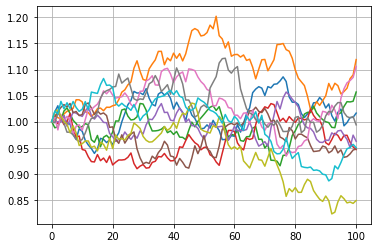

In [49]:
from pfhedge.instruments import BrownianStock
stock_GBM = BrownianStock()
print(stock_GBM.__dict__)

stock_GBM.simulate(n_paths=N_PATHS, time_horizon = 100 / 250, init_state=(1.0,))
paths_GBM = stock_GBM.spot

plt.plot(paths_GBM[:10].T)
plt.grid()
paths_GBM.shape

### Financial Derivatives

{'pricer': None, 'cost': 0.0, '_clauses': OrderedDict(), '_underliers': OrderedDict([('underlier', BrownianStock(sigma=0.2000, dt=0.0040))]), 'call': True, 'strike': 1.0, 'maturity': 0.08}


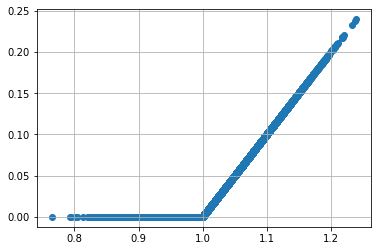

In [50]:
from pfhedge.instruments import EuropeanOption
EuropeanCallOption = EuropeanOption(stock_GBM)
print(EuropeanCallOption.__dict__)


EuropeanCallOption.simulate(N_PATHS)
payoff = EuropeanCallOption.payoff_fn()
underlying = EuropeanCallOption.ul()
prices = underlying.spot[:,-1]
plt.scatter(prices,payoff)
plt.grid()



### Hedgers

In [51]:
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron

model = MultiLayerPerceptron()
hedger = Hedger(model, inputs=["log_moneyness", "expiry_time", "volatility"])



/opt/homebrew/Caskroom/miniforge/base/envs/env_torch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [52]:
model

MultiLayerPerceptron(
  (0): LazyLinear(in_features=0, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=1, bias=True)
  (9): Identity()
)

In [53]:
# compute hedge
hedges = []
for t in range(10):
    inputs = hedger.inputs.of(EuropeanCallOption, hedger).get(t)
    hedge = hedger.model(inputs)
    hedges.append(hedge)

In [54]:
# compute terminal wealth
wealth = 0
for t in range(10):
    wealth += hedges[t][:,0,0]*(paths_GBM[:,t+1] - paths_GBM[:,t])
terminal_wealth = wealth - EuropeanCallOption.payoff_fn()

In [55]:
# compute loss 
from pfhedge.nn.functional import entropic_risk_measure
loss = entropic_risk_measure(terminal_wealth)

In [56]:
history = hedger.fit(EuropeanCallOption, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0227: 100%|██████████| 200/200 [12:30<00:00,  3.75s/it]


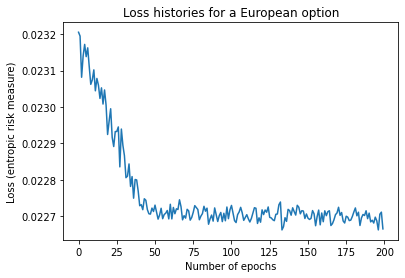

In [57]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

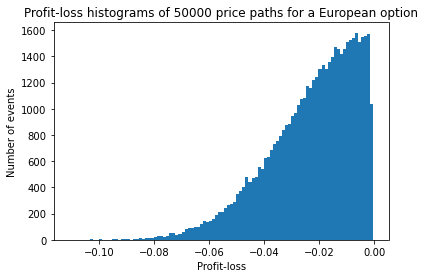

In [58]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.detach().numpy()

derivative = EuropeanCallOption
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [59]:
price = hedger.price(derivative)
price

tensor(0.0220)

### Black-Scholes' Delta-Hedging Strategy

In [60]:
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes

model = BlackScholes(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [61]:
hedger

Hedger(
  inputs=['log_moneyness', 'time_to_maturity', 'volatility']
  (model): BSEuropeanOption(strike=1.)
  (criterion): EntropicRiskMeasure()
)

In [62]:
price = hedger.price(derivative)
price

tensor(0.0225)

### Whalley-Wilmott's Asymptotically Optimal Strategy for Small Costs

In [63]:
from pfhedge.nn import Hedger
from pfhedge.nn import WhalleyWilmott

model = WhalleyWilmott(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [64]:
price = hedger.price(derivative)
price

tensor(0.0225)

### Your Own Module

In [65]:
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

from pfhedge.nn import BlackScholes, Clamp, MultiLayerPerceptron


class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()
        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]
        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])
        return self.clamp(prev_hedge, min=min, max=max)



In [66]:
model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs())

In [67]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0226: 100%|██████████| 200/200 [16:55<00:00,  5.08s/it]


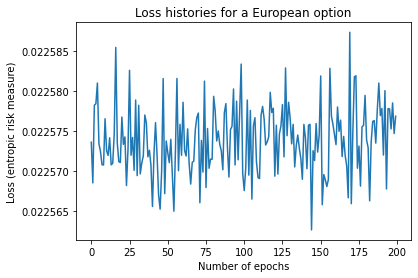

In [68]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

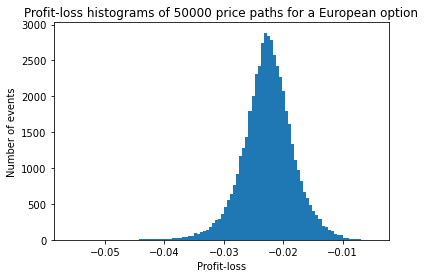

In [69]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [70]:
price = hedger.price(derivative)
price

tensor(0.0225)

### Use Expected Shortfall as a Loss function

In [71]:
from pfhedge.nn import ExpectedShortfall

In [72]:
# Expected shortfall with the quantile level of 10%
expected_shortfall = ExpectedShortfall(0.1)

model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs(), criterion=expected_shortfall).to(DEVICE)

In [73]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0305: 100%|██████████| 200/200 [10:04<00:00,  3.02s/it]


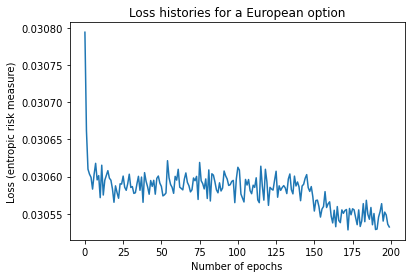

In [74]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

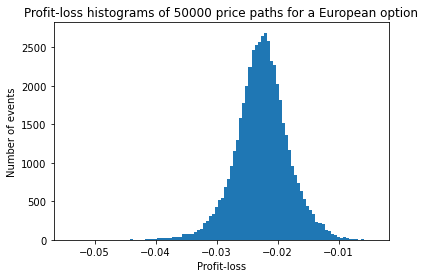

In [75]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [76]:
price = hedger.price(derivative)
price

tensor(0.0299)